In [73]:
from urllib.request import *
from bs4 import BeautifulSoup
import re
import pandas as pd
import numpy as np
import scipy.stats as stats
import pylab as pl
import requests
from geopy.geocoders import Nominatim
import json
from pygsp import graphs, filters, plotting
import os
import time
from tempfile import TemporaryFile
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
from scipy import sparse, stats, spatial
import scipy.sparse.linalg
import networkx as nx
from pylab import rcParams
plotting.BACKEND = 'matplotlib'
%matplotlib inline

## Folium

```
pip install folium
```

In [75]:
import folium
from folium.plugins import MarkerCluster

## GMAPS API

Quick summary to install GMAPS API if you need to run the map.

```
jupyter nbextension enable --py --sys-prefix widgetsnbextension
```

```
pip install gmaps
```

```
jupyter nbextension enable --py --sys-prefix gmaps
```

You might need to restart jupyter after installing.

*See [the installation instructions](https://github.com/pbugnion/gmaps#installation)*

**DO NOT SHARE THE FILE** gmapsKey in the folder ../scraper/data/gmapsKey



In [76]:
with open("../scraper/data/gmapsKey", "r") as infile:
    GMAPKEY = json.load(infile)["key"]
    
import gmaps
import gmaps.datasets
gmaps.configure(api_key=GMAPKEY)

## Data Scraping

All the data scraping process is done in the [Scraper](../scraper/Scraper.ipynb) Notebook.

The scraped data can be directly download with this 
# [??? LINK ???](???)

and **must be located in the folder scraper/data**

# Displaying clubs

All the methods used to obtains the clubs geographic location are commented in order to avoid redoing multiple requests. The locations obtained using requests were saved in a json file and are loaded in this Notebook.

## Loading clubs data

In [77]:
'''
with open("../scraper/data/clubs.json", "r") as in_file:
    clubs = json.load(in_file)
print("There are " + str(len(clubs)) + " clubs")
clubs[0]["href"]
'''

'\nwith open("../scraper/data/clubs.json", "r") as in_file:\n    clubs = json.load(in_file)\nprint("There are " + str(len(clubs)) + " clubs")\nclubs[0]["href"]\n'

In [78]:
# Create a club dictionnary to faster access. Save it as json to reload it faster.
'''
clubDict = {}
for club in clubs:
    club_id = club["href"].split("/")[4]
    if club_id not in clubDict:
        clubDict[club_id] = club
        
with open("../scraper/data/dictClubs.json", "w") as out:
    json.dump(clubDict, out)
'''

with open("../scraper/data/dictClubs.json", "r") as in_file:
    clubDict = json.load(in_file)

## Retrieve clubs coordinates using stadium and GoogleMap requests

In [79]:
'''GOOGLE_MAPS_API_URL = 'http://maps.googleapis.com/maps/api/geocode/json'

# For each club, we use its name and the stadium name to make a GoogleMap query and retrieve the stadium's coordinates
for club_id in clubDict.keys():
    club = clubDict[club_id]
    if "position" not in club:
        
        params = {
            'address': club["stadium"] + " " + club["name"]
        }
        # Do the request and get the response data
        req = requests.get(GOOGLE_MAPS_API_URL, params=params)
        res = req.json()
        # Use the first result
        if len(res['results']) > 0:
            result = res['results'][0]
            club["position"] = (result['geometry']['location']['lat'], result['geometry']['location']['lng'])
'''

'GOOGLE_MAPS_API_URL = \'http://maps.googleapis.com/maps/api/geocode/json\'\n\n# For each club, we use its name and the stadium name to make a GoogleMap query and retrieve the stadium\'s coordinates\nfor club_id in clubDict.keys():\n    club = clubDict[club_id]\n    if "position" not in club:\n        \n        params = {\n            \'address\': club["stadium"] + " " + club["name"]\n        }\n        # Do the request and get the response data\n        req = requests.get(GOOGLE_MAPS_API_URL, params=params)\n        res = req.json()\n        # Use the first result\n        if len(res[\'results\']) > 0:\n            result = res[\'results\'][0]\n            club["position"] = (result[\'geometry\'][\'location\'][\'lat\'], result[\'geometry\'][\'location\'][\'lng\'])\n'

In [80]:
'''
# For each club, we use its name and the stadium name to make a GoogleMap query and retrieve the stadium's coordinates
for club_id in clubDict.keys():
    club = clubDict[club_id]
    if "position" not in club:
        
        params = {
            'address': club["stadium"]
        }
        # Do the request and get the response data
        req = requests.get(GOOGLE_MAPS_API_URL, params=params)
        res = req.json()
        # Use the first result
        if len(res['results']) > 0:
            result = res['results'][0]
            club["position"] = (result['geometry']['location']['lat'], result['geometry']['location']['lng'])
'''

'\n# For each club, we use its name and the stadium name to make a GoogleMap query and retrieve the stadium\'s coordinates\nfor club_id in clubDict.keys():\n    club = clubDict[club_id]\n    if "position" not in club:\n        \n        params = {\n            \'address\': club["stadium"]\n        }\n        # Do the request and get the response data\n        req = requests.get(GOOGLE_MAPS_API_URL, params=params)\n        res = req.json()\n        # Use the first result\n        if len(res[\'results\']) > 0:\n            result = res[\'results\'][0]\n            club["position"] = (result[\'geometry\'][\'location\'][\'lat\'], result[\'geometry\'][\'location\'][\'lng\'])\n'

### Manual clean up

Check the clubs for which the coordinates couldn't be retrieved

In [81]:
'''
for club_id in clubDict.keys():
    club = clubDict[club_id]
    if "position" not in club:
        print(str(club_id) + ": " + club["name"])
'''

'\nfor club_id in clubDict.keys():\n    club = clubDict[club_id]\n    if "position" not in club:\n        print(str(club_id) + ": " + club["name"])\n'

Change manually the stadiums that couldn't be found with GoogleMaps.
We then rerun the google map coordinate retrieval

In [82]:
'''
clubs[93]["stadium"] = 'S.B.V. Excelsior'
clubs[170]["stadium"] = 'Başakşehir Fatih Terim Stadium'
clubs[208]["stadium"] = 'Lokeren Daknamstadion'
clubs[209]["stadium"] = 'KAS Eupen'
clubs[221]["stadium"] = 'Obolon Arena'
clubs[235]["stadium"] = 'FC Vysočina Jihlava'
clubs[20]["stadium"] = "Juventus Stadium"
clubs[261]["stadium"] = "Estadio León"
clubs[358]["stadium"] = "Estadio León"
'''

'\nclubs[93]["stadium"] = \'S.B.V. Excelsior\'\nclubs[170]["stadium"] = \'Başakşehir Fatih Terim Stadium\'\nclubs[208]["stadium"] = \'Lokeren Daknamstadion\'\nclubs[209]["stadium"] = \'KAS Eupen\'\nclubs[221]["stadium"] = \'Obolon Arena\'\nclubs[235]["stadium"] = \'FC Vysočina Jihlava\'\nclubs[20]["stadium"] = "Juventus Stadium"\nclubs[261]["stadium"] = "Estadio León"\nclubs[358]["stadium"] = "Estadio León"\n'

In [83]:
'''
# Example to realod a clubs location with modified stadium name
params = {
    'address': clubs[358]["stadium"] + " " + clubs[358]["name"]
}
# Do the request and get the response data
req = requests.get(GOOGLE_MAPS_API_URL, params=params)
res = req.json()
# Use the first result
if len(res['results']) > 0:
    result = res['results'][0]
    clubs[358]["position"] = (result['geometry']['location']['lat'], result['geometry']['location']['lng'])
'''

'\n# Example to realod a clubs location with modified stadium name\nparams = {\n    \'address\': clubs[358]["stadium"] + " " + clubs[358]["name"]\n}\n# Do the request and get the response data\nreq = requests.get(GOOGLE_MAPS_API_URL, params=params)\nres = req.json()\n# Use the first result\nif len(res[\'results\']) > 0:\n    result = res[\'results\'][0]\n    clubs[358]["position"] = (result[\'geometry\'][\'location\'][\'lat\'], result[\'geometry\'][\'location\'][\'lng\'])\n'

## Save/Load Clubs with location data

Save the clubs with data in order to reload them without making requests.

In [84]:
'''
with open("../scraper/data/clubs_with_location.json", "w") as out:
    json.dump(clubs, out)
'''
with open("../scraper/data/clubs_with_location.json", "r") as in_file:
    clubs = json.load(in_file)

# Display clubs on map

Display a map using Folium and add a marker for each of the clubs.

This gives us a quick overview of all the clubs we have info about, and let us check wether the coordinates have been correctly obtained.

In [85]:
m = folium.Map(location=[52, 15], zoom_start=4)
marker_cluster = MarkerCluster([]).add_to(m)
for club in clubs:
    folium.Marker(
        location=club["position"],
        popup=club["name"],
        icon=None,
    ).add_to(marker_cluster)
m

# Loading Players data

We now load the players data scraped, containin all infos about the players (name, nationality, age, current team) and all their transfers (from which club to which clubs, and the amount).

In [86]:
with open("../scraper/data/players_ref.json", "r") as in_file:
    players_ref_list = json.load(in_file)

In [87]:
print ("We have {} players".format(len(players_ref_list)))

We have 12075 players


In [88]:
# Get the amount of the transfer as an int from a string
def getTransferAmount(fee):
    try:
        if fee == "-" or fee == "?" or fee == "draft":
            return 0
        if "free" in fee or "Free" in fee:
            return 0
        if fee is not None:
            val = ".".join(fee.split(","))
            rest = val.split(" ")[1]
            val = val.split(" ")[0]

            if "Mill" in rest:
                return float(val) * 10**6
            else:
                if "Th" in rest: 
                    return float(val) * 10**3
                else:
                    return 0
        else:
            return 0
    except:
        return 0

In [89]:
# Define method to parse player given player url
def parsePlayer(player_ref):    
    playerID = player_ref.split("/")[-1]
    
    with open("../scraper/data/players/" + playerID + "/page.html") as in_file:
        player_page = json.load(in_file)
    
    response = BeautifulSoup(player_page, 'html.parser')
    
    playerInfos = str(response.find("table", {"class":"auflistung"}))
    player = {}
    player["href"] = player_ref
    try:
        player["number"] = response.find("span", {"class":"dataRN"}).text
    except:
        player["number"] = None
    player["name"] = response.find("h1", {"itemprop":"name"}).text
    player["player_id"] = player_ref.split("/")[-1]
    position = BeautifulSoup(playerInfos.split("Position")[1], 'html.parser').find("td").text
    reg = re.compile( "[a-zA-Z -]")
    player["position"] = "".join(reg.findall(position))
    try:
        player["birthdate"] = BeautifulSoup(playerInfos.split("Date of birth")[1], 'html.parser').find("td").text
    except:
        player["birthdate"] = None
    player["nationality"] = BeautifulSoup(playerInfos.split("Nationality")[1], 'html.parser').find("td").find("img")["title"]
    player["current_club"] = BeautifulSoup(playerInfos.split("Current club")[1], 'html.parser').find("td").find_all("a")[-1].text

    try:
        transfers = []
        trans = response.find("div",{"class" : "box transferhistorie"}).find("table").find("tbody").find_all("tr", {"class":"zeile-transfer"})

        for t in trans:
            transfer = {}
            transfer["player"] = player_ref.split("/")[-1]
            transfer["date"] = t.find_all("td", {"class":"zentriert hide-for-small"})[1].text
            transfer["from"] = t.find_all("td", {"class":"no-border-rechts vereinswappen"})[0].find("a")["id"]
            transfer["to"] = t.find_all("td", {"class":"no-border-rechts vereinswappen"})[1].find("a")["id"]
            if (t.find("td", {"class":"zelle-abloese"}).text) == "End of loan" or t.find("td", {"class":"zelle-abloese"}).text =="Loan":
                transfer["fee"] = t.find("td", {"class":"zelle-mw"}).text
            else:
                transfer["fee"] = t.find("td",{"class":"zelle-abloese"}).text
                        
            transfers.append(transfer)
    except:
        transfers = None
        
    return player, transfers

## Loading all players data and transfers

All players infos and transfers are loaded from the data scraped, and saved as a panda DataFrame. The DataFrame is saved as a json file to be loaded faster when restarting the Notebook.

In [90]:
'''
players_data = []
players_transfers = []
for player_id in players_ref_list:
    player = parsePlayer(player_id)
    players_data.append(player[0])
    players_transfers.append(player[1])
    
playersDF = pd.DataFrame(players_data)
playersDF["transfers"] = players_transfers

# Convert string fees to integers
for idx, player in playersDF.iterrows():
    if player["transfers"] is not None:
        for transfer in player["transfers"]:
            transfer["amount"] = getTransferAmount(transfer["fee"])

playersDF.to_json("../scraper/data/players.json")
'''

'\nplayers_data = []\nplayers_transfers = []\nfor player_id in players_ref_list:\n    player = parsePlayer(player_id)\n    players_data.append(player[0])\n    players_transfers.append(player[1])\n    \nplayersDF = pd.DataFrame(players_data)\nplayersDF["transfers"] = players_transfers\n\n# Convert string fees to integers\nfor idx, player in playersDF.iterrows():\n    if player["transfers"] is not None:\n        for transfer in player["transfers"]:\n            transfer["amount"] = getTransferAmount(transfer["fee"])\n\nplayersDF.to_json("../scraper/data/players.json")\n'

In [91]:
playersDF = pd.read_json("../scraper/data/players.json")
playersDF.head()

,birthdate,current_club,href,name,nationality,number,player_id,position,transfers
0,"May 11, 1992",Chelsea FC,/thibaut-courtois/profil/spieler/108390,Thibaut Courtois,Belgium,#13,108390,Goalkeeper,"[{'player': '108390', 'fee': '25,00 Mill. €', ..."
1,"Sep 28, 1981",Chelsea FC,/willy-caballero/profil/spieler/19948,Willy Caballero,Argentina,#1,19948,Goalkeeper,"[{'player': '19948', 'fee': 'Free transfer', '..."
10,"Feb 8, 1996",Chelsea FC,/kenedy/profil/spieler/281404,Kenedy,Brazil,#16,281404,Defence - Left-Back,"[{'player': '281404', 'fee': '8,00 Mill. €', '..."
100,"Feb 21, 1993",Everton FC,/davy-klaassen/profil/spieler/182932,Davy Klaassen,Netherlands,#20,182932,Midfield - Attacking Midfield,"[{'player': '182932', 'fee': '27,00 Mill. €', ..."
1000,"Oct 8, 1986",Chievo Verona,/fabrizio-cacciatore/profil/spieler/85605,Fabrizio Cacciatore,Italy,#29,85605,Defence - Right-Back,"[{'player': '85605', 'fee': '?', 'date': 'Jul ..."


In [92]:
playersDF.loc[1]["transfers"]

[{'amount': 0,
  'date': 'Jul 1, 2017',
  'fee': 'Free transfer',
  'from': '281',
  'player': '19948',
  'to': '631'},
 {'amount': 8000000.0,
  'date': 'Jul 8, 2014',
  'fee': '8,00 Mill. €',
  'from': '1084',
  'player': '19948',
  'to': '281'},
 {'amount': 900000.0,
  'date': 'Feb 21, 2011',
  'fee': '900 Th. €',
  'from': '1531',
  'player': '19948',
  'to': '1084'},
 {'amount': 1250000.0,
  'date': 'Jun 30, 2006',
  'fee': '1,25 Mill. €',
  'from': '4673',
  'player': '19948',
  'to': '1531'},
 {'amount': 1250000.0,
  'date': 'Jan 1, 2006',
  'fee': '1,25 Mill. €',
  'from': '1531',
  'player': '19948',
  'to': '4673'},
 {'amount': 700000.0,
  'date': 'Jul 1, 2004',
  'fee': '700 Th. €',
  'from': '189',
  'player': '19948',
  'to': '1531'},
 {'amount': 0,
  'date': 'Feb 1, 2002',
  'fee': '-',
  'from': '14831',
  'player': '19948',
  'to': '189'},
 {'amount': 0,
  'date': 'Jan 1, 2001',
  'fee': '-',
  'from': '15098',
  'player': '19948',
  'to': '14831'}]

### Data exploration and preprocessing functions
From the example above, one concern one can raise is the fact that the transfer fee is represented in a way that combines digits and characters. We want to cast the fee of transfer from string to int. All currencies are expressed in euros. We have found the below relations: <br/>
Mill. is used for millions <br/>
Th. is used for thousands <br/>
\- or ? is used to mark missing entry <br/>
Free Transfer is used to mark 0 value <br/>
Loan fee:amount is used to mark the value under a loan <br/>

In [93]:
missing_fees = 0
# This function will transform the fees of a player from a string to a number so that it can be used as a weight for the edges
def fix_fee(player_fee):
    # missing_fees is to count the number of 
    global missing_fees
    try:
        player_fee = player_fee.replace(":",": ").replace(",",".")
    except:
        pass
    if re.search(r'\d+.\d+', player_fee) is not None:
        fee = float(re.search(r'\d+.\d+', player_fee).group())
    else:
        fee = 0
    
    if fee > 0:
        if "Mill." in player_fee:
            processed_fee = int(fee*1000000)
        elif "Th." in player_fee:
            processed_fee = int(fee*1000)
        else:
            processed_fee = int(fee)
    else:
        missing_fees += 1
        processed_fee = 0
    
    return processed_fee

## Build graph of transfers

In [94]:
# We need to reduce the number of nodes to actual number of clubs. However, this will make us lose the indexing
width = len(clubs)
print ("The number of clubs that are valued above 200 Million Euros are {}".format(len(clubs)))

The number of clubs that are valued above 200 Million Euros are 418


### Build the graph ranked by value of club

We would like to build a graph that displays the interaction among clubs. An interaction is decided by if a player goes from one club to another (or vice versa). We have reasons to believe that clubs that have higher market values may tend to have more transfers among them, and clubs with smaller market values tend to interact more among each other. For this reason, we will build an adjacency matrix to build a graph sorted by the club's value.

In [95]:
# Our adjacency matrix should be 418x418
W = np.zeros((width,width))

In [96]:
# Create a list of tuple consisting of club id and market_value
club_pairs = []
for club in clubs:
    club_id = int(club['href'].split("/")[-3])
    club_market_value = int(fix_fee(club["market_value"]))
    club_pairs.append(tuple((club_market_value,club_id)))

# Sort list based on market value
club_pairs = sorted(club_pairs, key=lambda tup: tup[0])

club_ids = []

# Create a new list with the sorted club_ids based on their market value
for club in club_pairs:
    club_ids.append(club[1])

In [97]:
# Create a dictionary linking club ids to clubs data
clubs_ids_dict = {}
for club in clubs:
    club_id = int(club['href'].split("/")[-3])
    club["spending"] = 0
    club["earning"] = 0
    clubs_ids_dict[club_id] = club

In [98]:
transfer = playersDF.loc[1]["transfers"][0]

from_club = int(transfer["from"])
to_club = int(transfer["to"])

print(clubs_ids_dict[from_club]["name"])
print(clubs_ids_dict[to_club]["name"])

Manchester City
Chelsea FC


There are some players that are being transfered from one club to another, with the clubs being small (smaller than our criteria). The total number of clubs found was equal to 7200, however, we are only interested in the big clubs that we found were only 418. <br/>
We will add a constraint when adding the node.

In [99]:
# Fill the Adjacency matrix with one (W[i][j] == 1) when transfer from one club to another
# Where the two clubs match our 200 million euros valuation criteria
for idx, player in playersDF.iterrows():
    try:
        if player["transfers"] is not None:
            for transfer in player["transfers"]:
                from_club = int(transfer["from"])
                to_club = int(transfer["to"])
                
                if(from_club in club_ids and to_club in club_ids):
                    # Add link between the two clubs 
                    W[club_ids.index(from_club)][club_ids.index(to_club)] = 1
                    W[club_ids.index(to_club)][club_ids.index(from_club)] = 1
                    
                    #Add amount to the to and from clubs spending and earning respectivelly
                    clubs_ids_dict[to_club]["spending"] += transfer["amount"]
                    clubs_ids_dict[from_club]["earning"] += transfer["amount"]
    except:
        print("problem with " + player["name"] + " " + str(idx))

In [100]:
# Some transfers are within the same club. When a player contract came to an end.
number_of_inner_transfers = 0
for i in range(W.shape[0]):
    if(W[i][i] == 1):
        number_of_inner_transfers += 1
        
print ("There have been {} innertransfers".format(number_of_inner_transfers))

There have been 2 innertransfers


In [101]:
# Set all the transfers within the same club to zero -> no self-loops
# Ignore innertransfers
np.fill_diagonal(W, 0)

In [102]:
# Create a temporary matrix so we wouldn't need to recompute W if we later need to go back to our result
np.save('adj_matrix.npy', W)

## Load directly filled matrix

In [103]:
# Load W matrix from pre-saved model
W = np.load('adj_matrix.npy')

In [104]:
# Build graph from G
G = graphs.Graph(W)
print('{} nodes, {} edges'.format(G.N, G.Ne))

418 nodes, 6714 edges


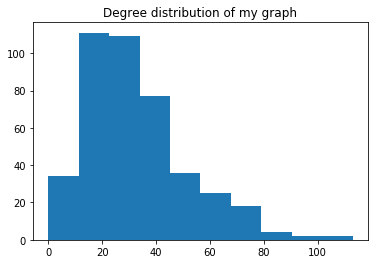

In [105]:
plt.hist(G.d)
plt.title('Degree distribution of my graph');

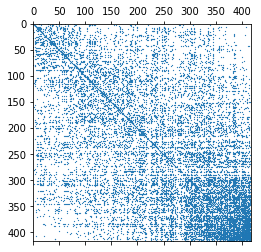

In [106]:
G.compute_laplacian('combinatorial')

plt.spy(G.L, markersize=0.30)


***We can see from the graph above that clubs do interact with each other. However there seems to be a formation of a cluster where interactions are more dense, that is the lowest 100 clubs (from a market value perspective) tend to interact more with each other. As the market value of the club is higher, we notice a lower interaction between clubs. Contrary to how media only covers the story of big football players going from a big club to another big one, we can clearly see that the majority of transfers are done in the smaller ones. This reason might be due to the high valuation of the player that is already in the big clubs. In fact, this finding explains why media might want to cover the transfer of big players, since we can see that these transfers are actually rare events that may lead to higher click through rate.***

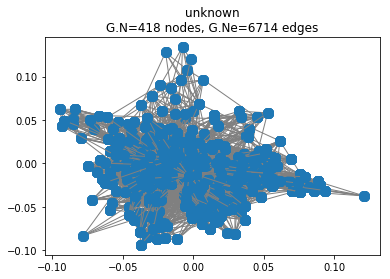

In [107]:
G.set_coordinates('spring')
plotting.plot_graph(G)

## Geographic analysis of transfers amount 

We use Heatmaps to show where the money is spent and earned during the big clubs transfers.

We create three heatmaps, one that represents the spendings, one the earn

In [109]:
locData = []
for club in clubs:
    locData.append([club["position"][0], club["position"][1]])
    
spendingData = []
earningData = []
benefitData = []
for club in clubs:
    spendingData.append(club["spending"])
    earningData.append(club["earning"])
    benefit = club["earning"]-club["spending"]
    benefitData.append(max(0, benefit))

In [110]:
maxSpent = max(list(map(lambda x: x, spendingData)))

In [111]:
maxEarned = max(list(map(lambda x: x, earningData)))

In [112]:
maxBenefit = max(list(map(lambda x: x, benefitData)))

### Spending Heatmap

In [113]:
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locData, weights=spendingData, max_intensity=maxSpent, point_radius=15))
fig

Figure()

### Earning Heatmap

In [114]:
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locData, weights=earningData, max_intensity=maxEarned, point_radius=15))
fig

Figure()

### Benefit Heatmap

In [115]:
fig = gmaps.figure()
fig.add_layer(gmaps.heatmap_layer(locData, weights=benefitData, max_intensity=maxBenefit, point_radius=15))
fig

Figure()

## Compute eigenvalues and eigenvectors

In [32]:
# Build graph using networkX and adjacency matrix W
G=nx.from_numpy_matrix(W)
laplacian = nx.normalized_laplacian_matrix(G)

In [86]:
eigenvalues, eigenvectors = scipy.sparse.linalg.eigs(laplacian, k = 10, which = 'SM')
print (eigenvalues)
print (eigenvectors.shape)

[  2.26177619e-01+0.j   2.54249921e-01+0.j   2.82996063e-01+0.j
   1.88990762e-16+0.j   2.78633018e-16+0.j  -8.15992858e-17+0.j
   1.23658466e-16+0.j  -1.14689760e-16+0.j   0.00000000e+00+0.j
   0.00000000e+00+0.j]
(418, 10)


/Users/fayezmourad/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


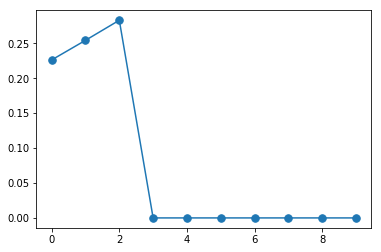

In [87]:
plt.plot(eigenvalues, '.-', markersize=15);

### Build graph based on geographic locations

We have reasons to believe that players in a certain country, will tend to transfer to another club in the same country. For this reason, we would like to build our adjacency matrix with the clubs in the same country be next to each other in the indexing.

In [51]:
# Our adjacency matrix should be 418x418
W = np.zeros((width,width))

In [52]:
club_ids = []
for club in clubs:
    club_ids.append(int(club['href'].split("/")[-3]))
    
club_ids = sorted(club_ids)

In [53]:
# Use google api to get the country where each club is located
GOOGLE_MAPS_API_URL = 'http://maps.googleapis.com/maps/api/geocode/json'
club_pairs = []
count_exception = 0
# From google maps api, get the country of each club
for club in clubs:
    club_id = int(club['href'].split("/")[-3])
    try:
        params = {
            'address': club["stadium"] + " " + club["name"]
        }
        # Do the request and get the response data
        req = requests.get(GOOGLE_MAPS_API_URL, params=params)
        res = req.json()
        # Use the first result
        if len(res['results']) > 0:
            result = res['results'][0]['address_components']
            for elem in result:
                if elem['types'][0] == 'country':
                    club_country = elem['long_name']
        club_pairs.append(tuple((club_country,club_id)))
    except:
        # If we weren't able to get the country of the club, we want to have it marked
        club_country = "Country not found"
        club_pairs.append(tuple((club_country,club_id)))
        count_exception = count_exception + 1
        pass
    
print ("Not able to find country for {} clubs".format(count_exception))

Not able to find country for 0 clubs


In [47]:
# Fill the Adjacency matrix with one when transfer from one club to another
# Where the two clubs match our 200 million euros valuation criteria
for player_ref in players_ref_list:
    player = parsePlayer(player_ref)
    try:
        for transfer in player[1]:
            from_club = int(transfer["from"])
            to_club = int(transfer["to"])
            if(from_club in club_ids and to_club in club_ids):
                W[club_ids.index(from_club)][club_ids.index(to_club)] = 1
                W[club_ids.index(to_club)][club_ids.index(from_club)] = 1
    except:
        pass

In [54]:
# Set all the transfers within the same club to zero -> no self-loops
np.fill_diagonal(W, 0)

In [55]:
# Create a temporary matrix so we wouldn't need to recompute W if we later need to go back to our result
np.save('adj_matrix_sorted_country.npy', W)

In [88]:
# Load W matrix from pre-saved model
W = np.load('adj_matrix_sorted_country.npy')

In [89]:
# Build graph from G
G = graphs.Graph(W)
print('{} nodes, {} edges'.format(G.N, G.Ne))

418 nodes, 6714 edges


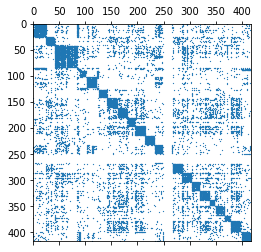

In [90]:
G.compute_laplacian('combinatorial')

plt.spy(G.L, markersize=0.30)

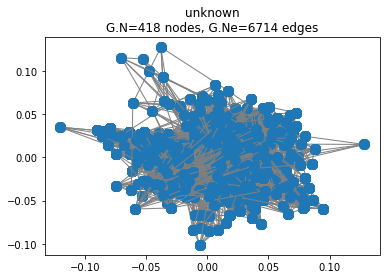

In [91]:
G.set_coordinates('spring')
plotting.plot_graph(G)

# Data visualization/exploration

In [96]:
# The average transfers of a player within these clubs
# Compute the number of interactions (Number of edges/2) over the number of players
print ("The average transfer of a player within these clubs is {}".format(G.Ne/(2*len(players_ref_list))))
    

The average transfer of a player within these clubs is 0.2780124223602484


In [36]:
player_nationalities = []
birthdays_month = []
counter = 0

for player_ref in players_ref_list:
    player = parsePlayer(player_ref)
    if counter % 1000 == 0:
        print ("We have processed {} players till now.".format(counter))
    try:
        player_nationalities.append(player[0]['nationality'])
        bday = player[0]["birthdate"].replace(",","").strip()
        datetime_object = datetime.strptime(bday, '%b %d %Y')
        birthdays_month.append(datetime_object.month)
    except:
        player_nationalities.append("N/A")
        # Mark not available birthday month by 13
        birthdays_month.append("13")
    counter += 1

We have processed 0 players till now.
We have processed 1000 players till now.
We have processed 2000 players till now.
We have processed 3000 players till now.
We have processed 4000 players till now.
We have processed 5000 players till now.
We have processed 6000 players till now.
We have processed 7000 players till now.
We have processed 8000 players till now.
We have processed 9000 players till now.
We have processed 10000 players till now.
We have processed 11000 players till now.
We have processed 12000 players till now.


### Players nationalities

In [37]:
# Sort nationalities by most common
nationalities_counter = Counter(player_nationalities).most_common(20)
index = []
iterator = 1
nationalities = []
nationalities_count = []
for nationality in nationalities_counter:
    index.append(iterator)
    iterator += 1
    nationalities.append(nationality[0])
    nationalities_count.append(nationality[1])

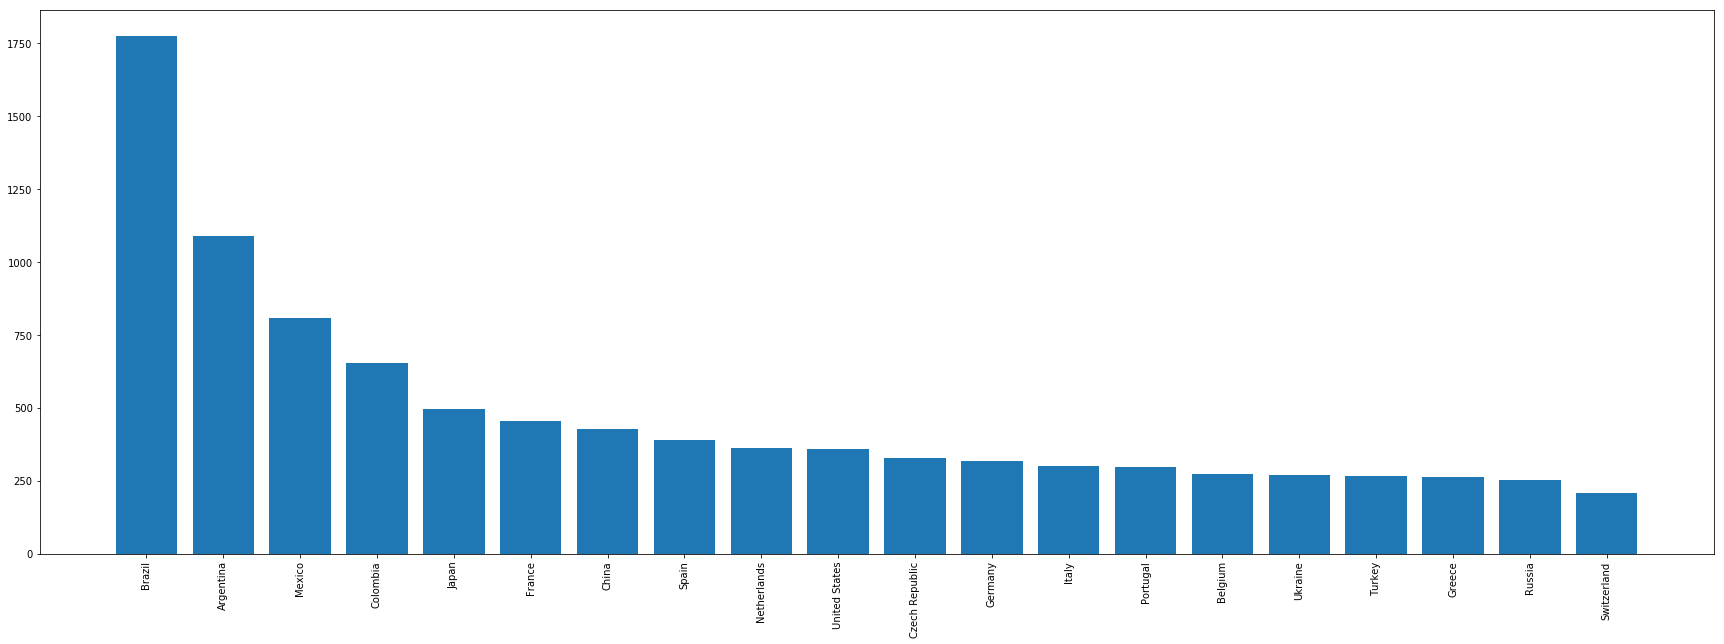

In [38]:
rcParams['figure.figsize'] = 30, 10
plt.bar(index, nationalities_count, align='center')
plt.xticks(index, nationalities,rotation=90)
plt.show()


### Clubs per country

In [39]:
# Visualize how many clubs each country has
clubs_country = []
for club in club_pairs:
    clubs_country.append(club[0])


In [40]:
clubs_country = Counter(clubs_country).most_common()

index = []
iterator = 1
countries = []
country_count = []

for country in clubs_country:
    index.append(iterator)
    iterator += 1
    countries.append(country[0])
    country_count.append(country[1])

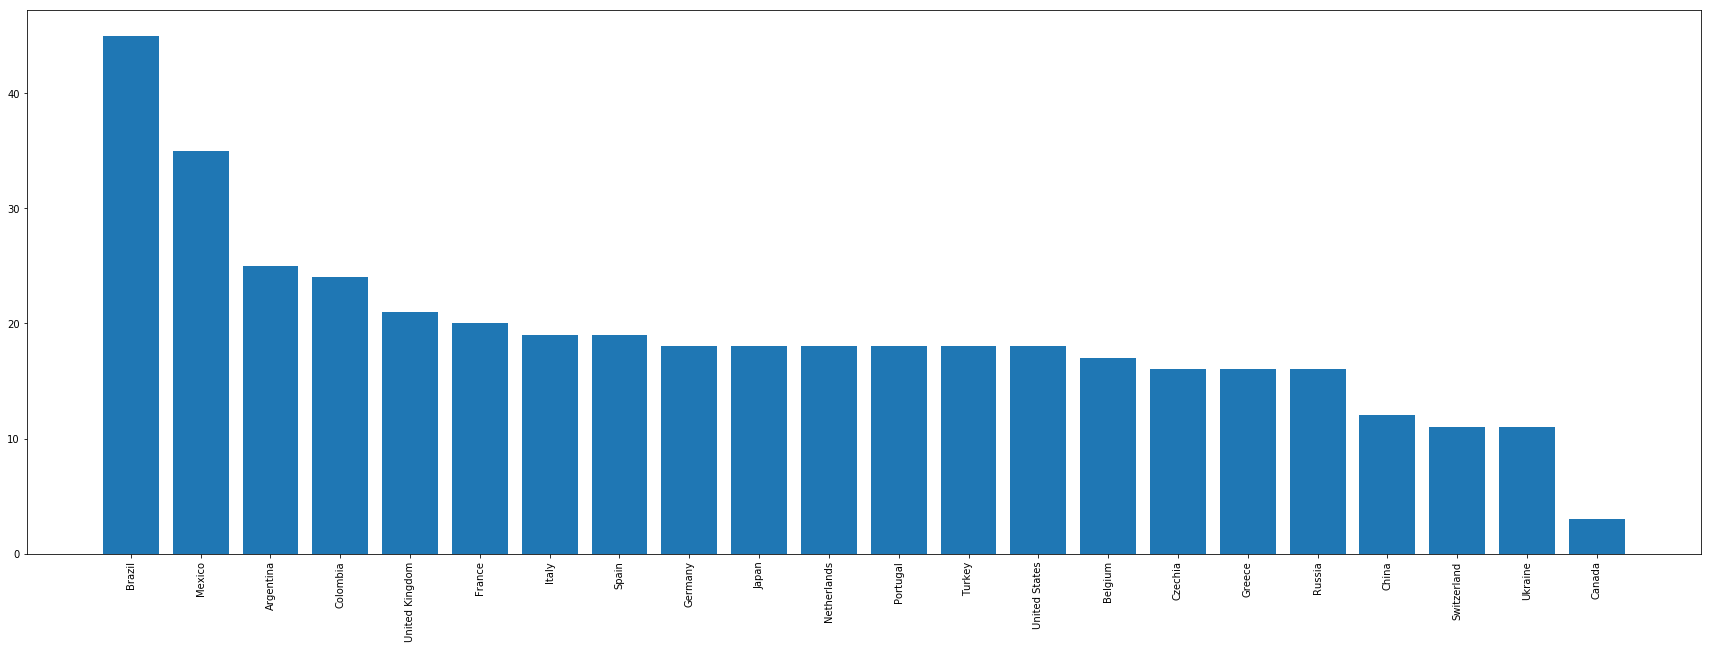

In [41]:
rcParams['figure.figsize'] = 30, 10
plt.bar(index, country_count, align='center')
plt.xticks(index, countries,rotation=90)
plt.show()

***From the two graphs before: The one showing the distribution of nationalities of football players and the one showing the number of clubs per country. We notice that the distribution is similar, i.e. Brazil that has the highest number of football players also has the highest numbers of clubs. This implication reinforce our assumption that the transfers might be dependent on geographical locations that has been shown in previous graph.***

### Player birthday distribution

In [42]:
birthdays_month = list(map(int, birthdays_month))
player_birthdays_month = Counter(birthdays_month).most_common()

player_birthdays_month = sorted(player_birthdays_month)

index = []
iterator = 1
months = []
month_count = []

for country in player_birthdays_month:
    index.append(iterator)
    iterator += 1
    months.append(country[0])
    month_count.append(country[1])

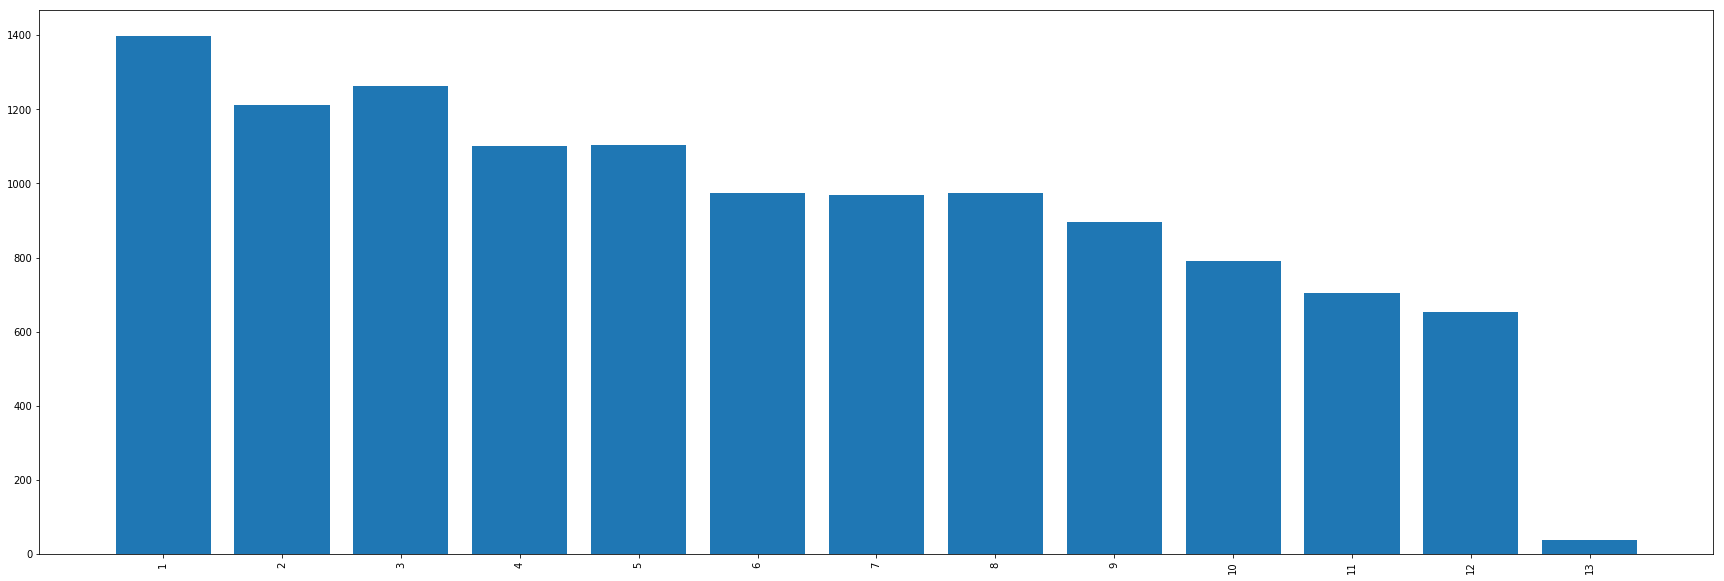

In [43]:
rcParams['figure.figsize'] = 30, 10
plt.bar(index, month_count, align='center')
plt.xticks(index, months,rotation=90)
plt.show()

***According to the book "Outliers" by Malcolm Gladwell, the distribution of professional athletes should be skewed. It is linked with the fact that when children are less than 10 years old, a month's difference in age makes a different from a performance point of view. The players who were born in the early phase of the year had a physical advantage over the other kids and had higher chances of being selected into clubs (usually the player selection is at a young age, less than or equal to 10 years old). This selection would cause a player to train more than the rest and hence higher his chances of becoming a professional atheles (hence professional football player). The arguments given by Malcolm Gladwell are shown to hold, specially since the distribution of birth is equally distributed with respect to month of birth.***

# Conclusion

We have examined clubs that are valued above 200 million euros. Three important findings were present: <br/>
1. Clubs with lower market value tend to interact more with each other. However, Clubs with higher market value have less interaction/transfers between each other. This may be due to the fact that a player has a high value that wouldn't explain the economics of buying him out.
2. Interactions are clustered by geographics. That is, clubs in the same country tend to interact more with each other.
3. The month distribution of players's birthdays is actually skewed and there are more players that are born at the beginning of the year than at the end. This is explained by Malcolm Gladwell in his book "Outliers", where he states that individuals born at the beginning of the year have an innate advantage during the player selection at a young age (10 years old)